## Imports

In [13]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models 
from torch.utils.data import DataLoader
import torch.nn as nn
import os
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import random
import PIL

## Importing Data

In [14]:
#UNCOMMENT IF YOU NEED TO DOWNLOAD DATASET------------------------------------------------------------------------------------------------------
#Download Dataset
# import opendatasets as od

# od.download("https://www.kaggle.com/datasets/aysendegerli/qatacov19-dataset/data")

In [15]:
from skimage import io

train_img_path = "/home/cahsi/Josh/Semantic_Segmentation_Research/LoRA_SAM/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Images/*.png"
test_img_path = "/home/cahsi/Josh/Semantic_Segmentation_Research/LoRA_SAM/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/*.png"

train_mask_path = "/home/cahsi/Josh/Semantic_Segmentation_Research/LoRA_SAM/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths/*.png"
test_mask_path = "/home/cahsi/Josh/Semantic_Segmentation_Research/LoRA_SAM/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/*.png"

# Load all images in the current folder that end with .png
train_img = io.imread_collection(train_img_path)
test_img = io.imread_collection(test_img_path)
train_mask = io.imread_collection(train_mask_path)
test_mask = io.imread_collection(test_mask_path)

#Images Info
print("Length of training raw images: " + str(len(train_img)) + "      Shape of an training raw image: " + str(train_img[0].shape))
print("Length of training mask images: " + str(len(train_mask)) + "     Shape of an training mask image: " + str(train_mask[0].shape))

print("\nLength of test raw images: " + str(len(test_img)) + "       Shape of an test raw image: " + str(test_img[0].shape))
print("Length of test mask images: " + str(len(test_mask)) + "      Shape of an test mask image: " + str(test_mask[0].shape))

Length of training raw images: 7145      Shape of an training raw image: (224, 224)
Length of training mask images: 7145     Shape of an training mask image: (224, 224)

Length of test raw images: 2113       Shape of an test raw image: (224, 224)
Length of test mask images: 2113      Shape of an test mask image: (224, 224)


## Resizing Images

In [4]:
from skimage.transform import resize
import cv2

def resize_images(images, mask):
    output = []
    if mask:
        for mask in images:
            # Perform resizing with nearest neighbor interpolation to maintain binary values
            resized_mask = (resize(mask, (256, 256), order=0, anti_aliasing=False) > 0.5).astype(np.uint8)
            output.append(resized_mask)
    else:
        for image in images:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            resized_image = resize(image, (256, 256), anti_aliasing=False)
            output.append(resized_image)
    
    return output

# Resize training images to 256x256
train_images = np.array(resize_images(train_img, False))

# Resize testing images to 256x256
test_img = np.array(resize_images(test_img, False))

# Resize training masks to 256x256
train_masks = np.array(resize_images(train_mask, True))

# Resize testing masks to 256x256
test_mask = np.array(resize_images(test_mask, True))

In [5]:
#Print Shape of resized images
print("Shape of resized training raw image: " + str(train_images.shape))
print("Shape of resized training mask image: " + str(train_masks.shape))
print("Shape of resized testing raw image: " + str(test_img.shape))
print("Shape of resized testing mask image: " + str(test_mask.shape))

Shape of resized training raw image: (7145, 256, 256, 3)
Shape of resized training mask image: (7145, 256, 256)
Shape of resized testing raw image: (2113, 256, 256, 3)
Shape of resized testing mask image: (2113, 256, 256)


## Get Subset of Data

In [6]:
from sklearn.model_selection import train_test_split

#Convert to subset of data
subset_size = 0.04

#>>>>> Comment if you want to use the full dataset for training
#train_images, _, train_masks, _ = train_test_split(train_images, train_masks, train_size=subset_size, random_state=25)

images = train_images
masks = train_masks

#Print Shape of resized images
print("Shape of resized training raw image: " + str(images.shape))
print("Shape of resized training mask image: " + str(masks.shape))

Shape of resized training raw image: (7145, 256, 256, 3)
Shape of resized training mask image: (7145, 256, 256)


## Create Datasets

In [7]:
from datasets import Dataset
from PIL import Image

img = [Image.fromarray((img * 255).astype(np.uint8)) for img in images]
label = [Image.fromarray(mask) for mask in masks]

# Create Validation Dataset
#X_train, X_val, y_train, y_val = train_test_split(img, label, test_size=0.1, random_state=42)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
training_dataset_dict = {
    "image": img,
    "mask": label,
}

training_dataset = Dataset.from_dict(training_dataset_dict)


In [8]:
#Check dataset info
print("Train Dataset Info:\n" + str(training_dataset))

Train Dataset Info:
Dataset({
    features: ['image', 'mask'],
    num_rows: 7145
})


## Visualize Data

In [9]:
import matplotlib.pyplot as plt
import numpy as np 

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

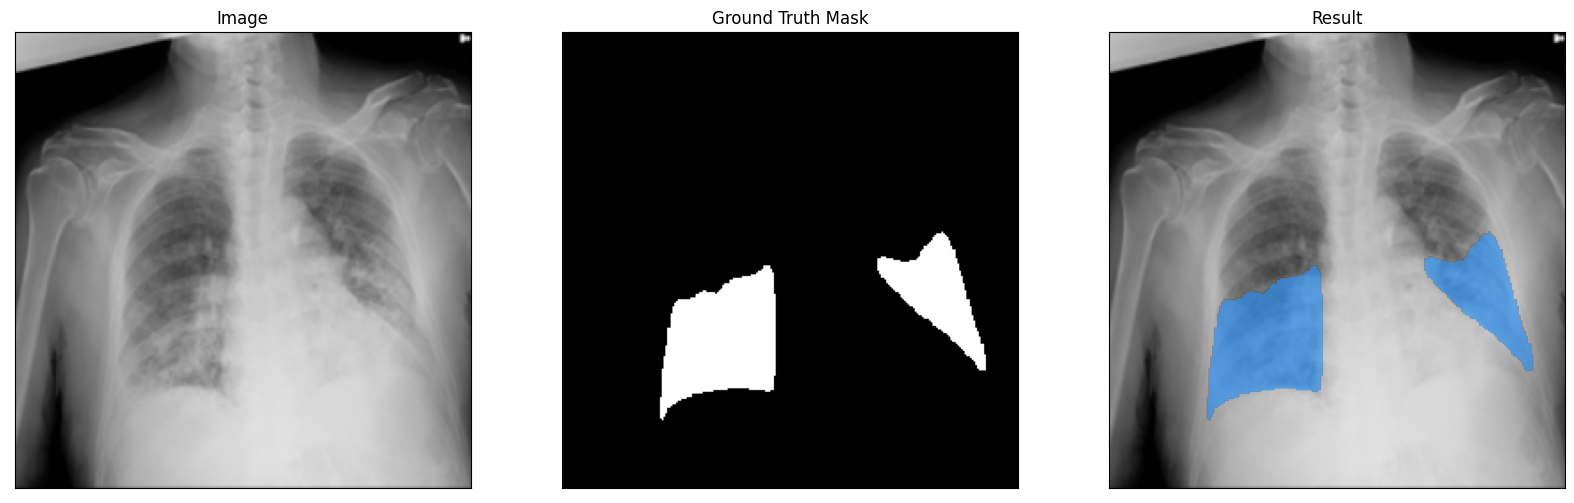

In [10]:
#Get random image from training set and plot
img_num = random.randint(0, images.shape[0]-1)
example_image = training_dataset[img_num]["image"]
example_mask = training_dataset[img_num]["mask"]

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image in the middle
axes[1].imshow(np.array(example_mask), cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Ground Truth Mask")

# Plot them overlapped on the right
axes[2].imshow(np.array(example_image), cmap='gray')  # Assuming the second image is grayscale
show_mask(np.array(example_mask), axes[2])
axes[2].set_title("Result")


# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

### Get Bounding Boxes

In [11]:
#Function that gets bounding boxes from masks
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

### SAM Dataset/Processor

In [12]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["mask"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [16]:
# Initialize the processor
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=training_dataset, processor=processor)

# # Create an instance of the SAMDataset
# val_dataset = SAMDataset(dataset=val_dataset, processor=processor)

In [17]:
# # Create a DataLoader instance for the training/validation dataset
# from torch.utils.data import DataLoader

# train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
# #val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True, drop_last=False)

# print("Training: \n")
# train_batch = next(iter(train_dataloader))
# for k,v in train_batch.items():
#   print(k,v.shape)

# print("Ground Truth Mask Shape: " + str(train_batch["ground_truth_mask"].shape))

# # print("Validation: \n")
# # val_batch = next(iter(val_dataloader))
# # for k,v in val_batch.items():
# #   print(k,v.shape)

# #print("Ground Truth Mask Shape: " + str(val_batch["ground_truth_mask"].shape))

In [18]:
# Load SAM model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for vision encoder
for name, param in model.named_parameters():
  if name.startswith("prompt_encoder"):# or name.startswith("vision_encoder"):
    param.requires_grad_(False)

### LoRA Config

In [19]:
#Original number of parameters
original_sam_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [20]:
import loralib as lora

rank = 2

# VISION ENCODER -----------------------------------------------------------------------------------------------------------
# # Patch embedding
# model.vision_encoder.patch_embed.projection = lora.Conv2d(3, 768, kernel_size=16, stride=(16, 16), r = rank)

for layer in model.vision_encoder.layers:
    #Attention block
    layer.attn.qkv = lora.MergedLinear(768, 2304, r=rank, enable_lora=[True, True, True])
    # layer.attn.proj = lora.Linear(768, 768, r=rank)
    
#     # #MLP block
#     layer.mlp.lin1 = lora.Linear(768, 3072, r=rank)
#     layer.mlp.lin2 = lora.Linear(3072, 768, r=rank)

# #Neck Layer
# model.vision_encoder.neck.conv1 = lora.Conv2d(768, 256, kernel_size=1, stride=(1, 1), r=rank)
# model.vision_encoder.neck.conv2 = lora.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=(1, 1), r=rank)


# MASK DECODER -----------------------------------------------------------------------------------------------------------
for layer in model.mask_decoder.transformer.layers:
    #Self attention block
    layer.self_attn.q_proj = lora.Linear(256, 256, r=rank)
    layer.self_attn.k_proj = lora.Linear(256, 256, r=rank)
    layer.self_attn.v_proj = lora.Linear(256, 256, r=rank)
#     layer.self_attn.out_proj = lora.Linear(256, 256, r=rank)

#     #Cross attention block (Token -> Image)
#     layer.cross_attn_token_to_image.q_proj = lora.Linear(256, 128, r=rank)
#     layer.cross_attn_token_to_image.k_proj = lora.Linear(256, 128, r=rank)
#     layer.cross_attn_token_to_image.v_proj = lora.Linear(256, 128, r=rank)
#     layer.cross_attn_token_to_image.out_proj = lora.Linear(128, 256, r=rank)

#     #MLP block
#     layer.mlp.lin1 = lora.Linear(256, 2048, r=rank)
#     layer.mlp.lin2 = lora.Linear(2048, 256, r=rank)
    
#     #Cross attention block (Image -> Token)
#     layer.cross_attn_image_to_token.q_proj = lora.Linear(256, 128, r=rank)
#     layer.cross_attn_image_to_token.k_proj = lora.Linear(256, 128, r=rank)
#     layer.cross_attn_image_to_token.v_proj = lora.Linear(256, 128, r=rank)
#     layer.cross_attn_image_to_token.out_proj = lora.Linear(128, 256, r=rank)

# #Final attention block (Token -> Image)
# model.mask_decoder.transformer.final_attn_token_to_image.q_proj = lora.Linear(256, 128, r=rank)
# model.mask_decoder.transformer.final_attn_token_to_image.k_proj = lora.Linear(256, 128, r=rank)
# model.mask_decoder.transformer.final_attn_token_to_image.v_proj = lora.Linear(256, 128, r=rank)
# model.mask_decoder.transformer.final_attn_token_to_image.out_proj = lora.Linear(128, 256, r=rank)

In [21]:
print(f"Original SAM total params: {original_sam_total_params}")

sam_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"LoRA-SAM total params: {sam_total_params}")

Original SAM total params: 93729252
LoRA-SAM total params: 72219108


### Train Model

In [22]:
from torch.optim import Adam
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
import monai

# Initialize the optimizer and the loss function
optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=0)

#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# Set Up GPU Process Group
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

#Split the data for each GPU
def prepare(rank, world_size, batch_size=32, pin_memory=False, num_workers=0):
    dataset = train_dataset
    sampler = DistributedSampler(dataset, num_replicas=world_size, rank=rank, shuffle=False, drop_last=False)
    dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers, drop_last=False, shuffle=False, sampler=sampler)
    
    return dataloader

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 20
mean_epoch_loss = []
world_size = 2

# This sets requires_grad to False for all parameters without the string "lora_" in their names
#lora.mark_only_lora_as_trainable(model)

# #Set layer-norms in VISION ENCODER to be trainable
# for layer in model.vision_encoder.layers:
#     layer.layer_norm1.requires_grad_(True)
#     layer.layer_norm2.requires_grad_(True)
# model.vision_encoder.neck.layer_norm1.requires_grad_(True)
# model.vision_encoder.neck.layer_norm2.requires_grad_(True)

# #Set layer-norms in MASK DECODER to be trainable
# for layer in model.mask_decoder.transformer.layers:
#     layer.layer_norm1.requires_grad_(True)
#     layer.layer_norm2.requires_grad_(True)
#     layer.layer_norm3.requires_grad_(True)
#     layer.layer_norm4.requires_grad_(True)
# model.mask_decoder.transformer.layer_norm_final_attn.requires_grad_(True)

# setup the process groups
setup(rank, world_size)
# prepare the dataloader
dataloader = prepare(rank, world_size)

# instantiate the model(it's your own model) and move it to the right device
model = model().to(rank)

# wrap the model with DDP
# device_ids tell DDP where is your model
# output_device tells DDP where to output, in our case, it is rank
# find_unused_parameters=True instructs DDP to find unused output of the forward() function of any module in the model
model = DDP(model, device_ids=[rank], output_device=rank, find_unused_parameters=True)



#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:7")
model = model.to(device)

model.train()
for epoch in range(num_epochs):
    dataloader.sampler.set_epoch(epoch)  
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    mean_epoch_loss.append(mean_epoch_loss)

In [ ]:
# # Save the model's state dictionary to a file
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': mean(epoch_losses),
#             }, f"/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/LoRA_SAM/LoRA_sam_model_checkpoint_rank{rank}.pth")

# # Save the LoRA parameters of the model
# torch.save(lora.lora_state_dict(model), f"/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/LoRA_SAM/lora_rank{rank}.pt")

### Inference

In [ ]:
# # Load the model configuration
# model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
# processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# # Create an instance of the model architecture with the loaded configuration
# lora_model = SamModel(config=model_config)

# #Load pretrained model
# lora_model.load_state_dict(torch.load(f"/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/LoRA_SAM/LoRA_sam_model_checkpoint_rank{rank}.pth"), strict=False)

# #Load LoRA checkpoint
# lora_model.load_state_dict(torch.load(f"/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/LoRA_SAM/lora_rank{rank}.pt"), strict=False)

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
lora_model = model
lora_model.to(device)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, images.shape[0]-1)

# load image
test_image = training_dataset[idx]["image"]
test_image = np.array(test_image.convert("RGB"))

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(training_dataset[idx]["mask"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

lora_model.eval()

# forward pass
with torch.no_grad():
    outputs = lora_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Plot the first image on the left
axes[0].imshow(test_image, cmap='gray')  # Assuming the first image is grayscale
show_mask(np.array(ground_truth_mask), axes[0])
axes[0].set_title("Ground Truth Mask")

# Plot the second image on the right
axes[1].imshow(test_image, cmap='gray')  # Assuming the second image is grayscale
show_mask(np.array(medsam_seg), axes[1])
axes[1].set_title("Predicted Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

### Further Analysis

In [ ]:
def calculateIoU(ground_mask, pred_mask):
        # Calculate the TP, FP, FN
        TP = 0
        FP = 0
        FN = 0
 
        for i in range(len(ground_mask)):
            for j in range(len(ground_mask[0])):
                if ground_mask[i][j] == 1 and pred_mask[i][j] == 1:
                    TP += 1
                elif ground_mask[i][j] == 0 and pred_mask[i][j] == 1:
                    FP += 1
                elif ground_mask[i][j] == 1 and pred_mask[i][j] == 0:
                    FN += 1
 
        # Calculate IoU
        iou = TP / (TP + FP + FN)
 
        return iou

In [ ]:
example_ground_mask = np.array(training_dataset[idx]["mask"])
print(f"IoU: {calculateIoU(example_ground_mask, medsam_seg)}")

##### IOU Over 100 Test Images

In [ ]:
from datasets import Dataset
from PIL import Image

test_size = 100
#test_size = len(test_img)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
test_dataset_dict = {
    "image": [Image.fromarray((img * 255).astype(np.uint8)) for img in test_img[:test_size]],
    "mask": [Image.fromarray(mask) for mask in test_mask[:test_size]],
}

# Create the dataset using the datasets.Dataset class
test_dataset = Dataset.from_dict(test_dataset_dict)

test_ious = []
model.to(device)
for idx, sample in enumerate(test_dataset):
    # Get Image and ground truth mask
    image = sample["image"]
    ground_truth_mask = np.array(sample["mask"])
    
    # get box prompt based on ground truth segmentation map
    prompt = get_bounding_box(ground_truth_mask)
    
    # prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
    #inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    
    # forward pass
    with torch.no_grad():
      outputs = model(**inputs, multimask_output=False)
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    iou = calculateIoU(ground_truth_mask, medsam_seg)
    print(f"Sample {idx} IoU: {iou}")
    test_ious.append(iou)

    
print(f"Average IoUs over {test_size} test sample: {mean(test_ious)}")

#####  IOU Over All Test Images

In [ ]:
from datasets import Dataset
from PIL import Image

#test_size = 100
test_size = len(test_img)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
test_dataset_dict = {
    "image": [Image.fromarray((img * 255).astype(np.uint8)) for img in test_img[:test_size]],
    "mask": [Image.fromarray(mask) for mask in test_mask[:test_size]],
}

# Create the dataset using the datasets.Dataset class
test_dataset = Dataset.from_dict(test_dataset_dict)

test_ious = []
model.to(device)
for idx, sample in enumerate(test_dataset):
    # Get Image and ground truth mask
    image = sample["image"]
    ground_truth_mask = np.array(sample["mask"])
    
    # get box prompt based on ground truth segmentation map
    prompt = get_bounding_box(ground_truth_mask)
    
    # prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
    #inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    
    # forward pass
    with torch.no_grad():
      outputs = model(**inputs, multimask_output=False)
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    iou = calculateIoU(ground_truth_mask, medsam_seg)
    print(f"Sample {idx} IoU: {iou}")
    test_ious.append(iou)

    
print(f"Average IoUs over {test_size} test sample: {mean(test_ious)}")

# Experiment Results

**Model 1**
- Train Size = ALL
- Rank = **100**
- Train Epochs = **10**
- Test IOU (Over 100 samples)= **0.34**
- Test IOU (Over all Test Data): **0.29729**
- **Layers Edited**

    - model.mask_decoder.transformer.layers:
        - layer.self_attn.q_proj 
        - layer.self_attn.k_proj 
        - layer.self_attn.v_proj

        - layer.mlp.lin1
        - layer.mlp.lin2

        - layer.cross_attn_image_to_token.q_proj
        - layer.cross_attn_image_to_token.k_proj
        - layer.cross_attn_image_to_token.v_proj

        - layer.cross_attn_image_to_token.q_proj
        - layer.cross_attn_image_to_token.k_proj
        - layer.cross_attn_image_to_token.v_proj

        - layer.layer_norm1

    - for layer in model.mask_decoder.transformer.layers:
        - layer.layer_norm1
        - layer.layer_norm2
        - layer.layer_norm3
        - layer.layer_norm4

    - model.mask_decoder.transformer.final_attn_token_to_image.q_proj
    - model.mask_decoder.transformer.final_attn_token_to_image.k_proj
    - model.mask_decoder.transformer.final_attn_token_to_image.v_proj

**Model 2**
- Train Size = ALL
- Rank = **100**
- Train Epochs = **15**
- Mean loss: **0.739632799216355**
- Test IOU (Over 100 samples)= **0.24396120759504994**
- Test IOU (Over all Test Data): **0.28765982855840583**
- **Layers Edited**: (Same as above)

**Model 3**
- Train Size = **ALL**
- Rank = **250**
- Train Epochs = **10**
- Mean loss: **0.7362756259945838**
- Test IOU (Over 100 samples)= **0.242310915626478**
- Test IOU (Over all Test Data): **0.30517595636914663**
- **Layers Edited**: (Same as above)

**Model 4**
- Train Size = **ALL**
- Rank = **10**
- Train Epochs = **20**
- Mean loss: **0.3595123540744573**
- Test IOU (Over 100 samples)= **0.5290344924635371**
- **Layers Edited**: All Vision Enocder, All Mask Decoder, Normalization Layers were trained as well

**Model 5**
- Train Size = **ALL**
- Rank = **25**
- Train Epochs = **20**
- Mean loss: **0.2858704915053865**
- Test IOU (Over 100 samples)= **0.5933433472033873**
- Test IOU (Over all Test Data): **0.6708022050721741**
- **Layers Edited**: All Vision Enocder, All Mask Decoder, Normalization Layers were trained as well

-----------------------------------------------------------------------------------

**Original SAM (W/O LoRA)**
- Train Size = **ALL**
- Rank = **None**
- Train Epochs = **20**
- Mean loss: **0.07050003955156871**
- Test IOU (Over 100 samples)= **0.7202856028634871**
- Test IOU (Over all Test Data): **0.7774607072278246**
- **Layers Edited**: None

**Model 6**
- Train Size = **ALL**
- Rank = **10**
- Train Epochs = **20**
- Mean loss: **0.1657026837598934**
- Test IOU (Over 100 samples)= **0.6702685182673397**
- Test IOU (Over all Test Data): **0.7443639897938635**
- **Layers Edited**: QKV layers from Vision Enocder and Mask Decoder

**Model 7**
- Train Size = **ALL**
- Rank = **10**
- Train Epochs = **20**
- Mean loss: **0.2594345606448535**
- Test IOU (Over 100 samples)= **0.6253727173045005**
- Test IOU (Over all Test Data): **0.6948658898529892**
- **Layers Edited**: QKV layers and MLP layers from Vision Enocder and Mask Decoder

**Model 8**
- Train Size = **ALL**
- Rank = **10**
- Train Epochs = **20**
- Mean loss: **0.25178625939057847**
- Test IOU (Over 100 samples)= **0.6302336585579551**
- Test IOU (Over all Test Data): **0.6881568610129997**
- **Layers Edited**: QKV and MLP layers + layer norms from Vision Enocder and Mask Decoder

**Model 9**
- Train Size = **ALL**
- Rank = **10**
- Train Epochs = **20**
- Mean loss: **0.2869026016620171**
- Test IOU (Over 100 samples)= **0.5716214652046244**
- Test IOU (Over all Test Data): **0.652137245664665**
- **Layers Edited**: QKV and MLP layers (including out_proj layers) + layer norms from Vision Enocder and Mask Decoder


**Model 10**
- Train Size = **ALL**
- Rank = **10**
- Train Epochs = **20**
- Mean loss: **0.31074020895442805**
- Test IOU (Over 100 samples)= **0.5697023371616273**
- Test IOU (Over all Test Data): **0.650287439480315**
- **Layers Edited**: All layers

-------------------------
**Adjusting Ranks**

Baseline
- Mean loss: **0.07050003955156871**
- Test IOU (Over 100 samples)= **0.7202856028634871**
- Test IOU (Over all Test Data): **0.7774607072278246**

**Model 11**
- Train Size = **ALL**
- Rank = **20**
- Train Epochs = **20**
- Mean loss: **0.15409883258516568**
- Test IOU (Over 100 samples)= **0.706868248336556**
- Test IOU (Over all Test Data): **0.7615486503716627**
- **Layers Edited**: Only self attention blocks in both vision encoder and mask decoder

**Model 12**
- Train Size = **ALL**
- Rank = **100**
- Train Epochs = **20**
- Mean loss: **0.1575793492199325**
- Test IOU (Over 100 samples)= **0.699975307532582**
- Test IOU (Over all Test Data): **0.755494044484111**
- **Layers Edited**: Only self attention blocks in both vision encoder and mask decoder

**Model 13**
- Train Size = **ALL**
- Rank = **3**
- Train Epochs = **20**
- Mean loss: **0.15462210127161624**
- Test IOU (Over 100 samples)= **0.7169591991935994**
- Test IOU (Over all Test Data): **0.7613847020166868**
- **Layers Edited**: Only self attention blocks in both vision encoder and mask decoder

**Model 14**
- Train Size = **ALL**
- Rank = **2**
- Train Epochs = **20**
- Mean loss: **0.15569957190060563**
- Test IOU (Over 100 samples)= **0.6973466387152136**
- Test IOU (Over all Test Data): **0.7612551539754306**
- **Layers Edited**: Only self attention blocks in both vision encoder and mask decoder

https://github.com/MathieuNlp/Sam_LoRA?tab=readme-ov-file

https://github.com/NielsRogge/Transformers-Tutorials/tree/master/SAM

# **Next Steps**

1) Change up the trainable parameter

    - **Training all bias vectors associated with modules we apply LoRA to**

            lora.mark_only_lora_as_trainable(model, bias='lora_only')

    - **Alternatively, we can train *all* bias vectors in the model, including LayerNorm biases**

            lora.mark_only_lora_as_trainable(model, bias='all')

2) Only use LoRA on q & v projection